(100,)


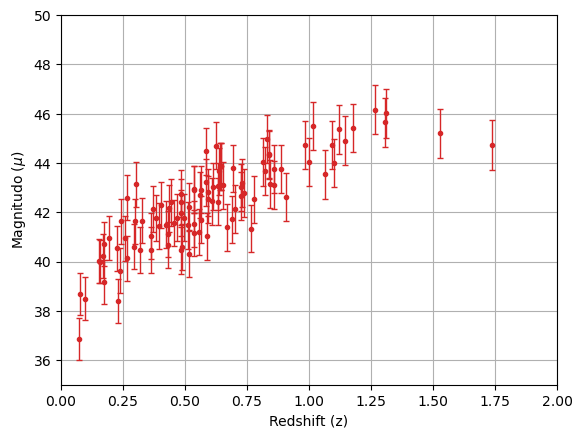

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

print(np.shape(z_sample))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.', lw=1, capsize = 2, label='data', color='tab:red' )
plt.xlabel("Redshift (z)")
plt.ylabel(rf"Magnitudo $(\mu)$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid()

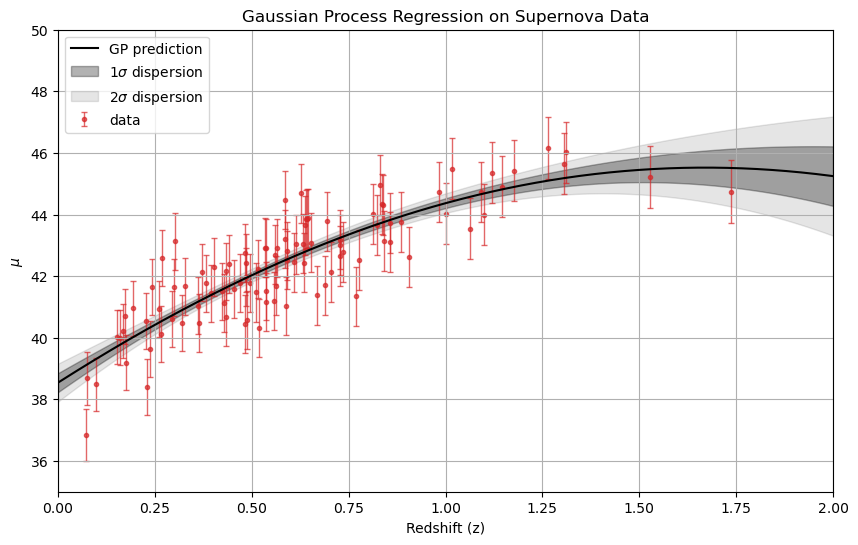

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf_kernel =  ConstantKernel(1.0, (1e-3, 1e3))*RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2))  # RBF kernel with a length scale of 0.1
# The length_scale_bounds parameter allows the optimizer to adjust the length scale during fitting
gp = GaussianProcessRegressor(kernel=rbf_kernel, alpha = dmu**2, n_restarts_optimizer=10)  #I've added 10 optimization iterations
gp.fit(z_sample.reshape(-1,1), mu_sample)
z_fit = np.linspace(0, 2, 1000)
mu_pred, dmu_pred = gp.predict(z_fit.reshape(-1,1), return_std=True)

fig2,ax2= plt.subplots(figsize=(10,6))
ax2.plot(z_fit, mu_pred, label='GP prediction', color = 'black', zorder=5)
ax2.fill_between(z_fit, mu_pred-dmu_pred, mu_pred+dmu_pred, alpha=0.3, label=rf'1$\sigma$ dispersion', color = 'black', zorder=1)
ax2.fill_between(z_fit, mu_pred-2*dmu_pred, mu_pred+2*dmu_pred, alpha=0.1, label=rf'2$\sigma$ dispersion', color = 'black', zorder=1)
ax2.errorbar(z_sample, mu_sample, dmu, fmt='.', lw=1, capsize = 2, label='data', color = 'tab:red', alpha=0.7, zorder=1)
ax2.set_title("Gaussian Process Regression on Supernova Data")
ax2.grid()
ax2.set_xlabel("Redshift (z)")
ax2.set_ylabel(rf"$\mu$")
ax2.set_xlim(0,2)
ax2.set_ylim(35,50)
ax2.legend()


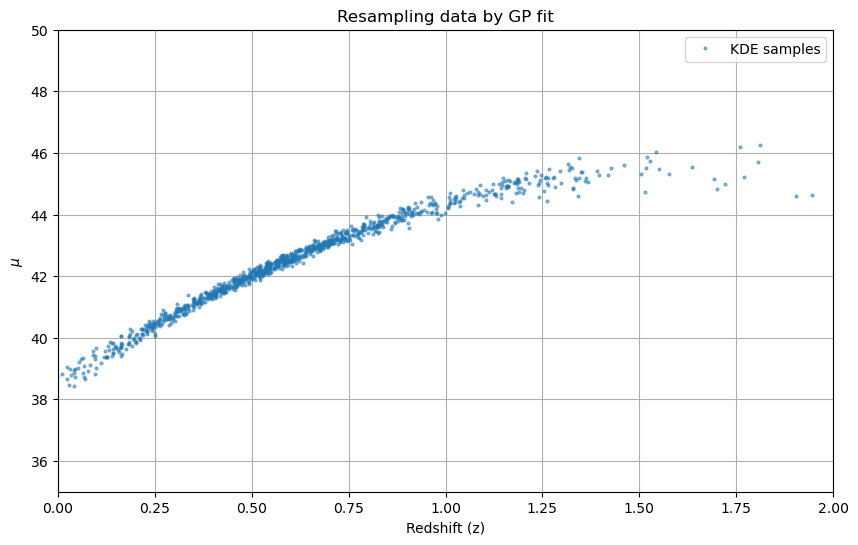

In [7]:
from sklearn.neighbors import KernelDensity

fig3, ax3 = plt.subplots(figsize=(10,6))
kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
kde.fit(z_sample.reshape(-1, 1))
z_copy = kde.sample(1000, random_state=42)
mu_gp, dmu_gp = gp.predict(z_copy.reshape(-1, 1), return_std=True) 
mu_copy = mu_gp + np.random.normal(0, dmu_gp)  # Adding noise to the GP prediction
ax3.plot(z_copy, mu_copy, 'o', markersize=2, label='KDE samples', color='tab:blue', alpha=0.5)
ax3.set_title("Resampling data by GP fit")
ax3.set_xlabel("Redshift (z)")
ax3.set_ylabel(rf"$\mu$")
ax3.set_xlim(0,2)
ax3.set_ylim(35,50)
ax3.grid()
ax3.legend()



In [8]:
#MANCA LA PARTE DI MODEL FITTING